# Acquiring Data From BigQuery #

In [50]:
import os
import pandas
import numpy as np
import pickle

from google.cloud import bigquery
client = bigquery.Client()

QUERY = """
        SELECT repo_name, language
        FROM `bigquery-public-data.github_repos.languages`
        ORDER BY rand()
        LIMIT 500
        """

query_job = client.query(QUERY)

iterator = query_job.result(timeout=30)
rows = list(iterator)
    
with open('./data/raw','wb') as file:
    pickle.dump(rows,file,-1)

for i in range(10):
    for j in rows[i].language:
        print j[u'name']
    print 

CSS
JavaScript
Python

CSS
HTML
JavaScript
PHP

CSS
JavaScript
Python

Go
Groff
Makefile
Shell

JavaScript

C#

Python

HTML

CSS
JavaScript
PHP

C#



# List of Languages #

In [51]:
#sourced from githut 
df = pandas.read_csv('data/language_names.csv')
names = df['language_name'].tolist()

name_to_index = {}
for j,i in enumerate(names):
    name_to_index[i] = j

# Repository-Language Matrix #

In [52]:
from math import log

global mat
mat = np.zeros((len(rows),len(names)))
for i,row in enumerate(rows):
    total = sum([log(lang[u'bytes']) if lang[u'bytes']!=0 else 0 for lang in row[1]])
    for lang in rows[i].language:
        mat[i][name_to_index[lang[u'name']]] = (log(lang[u'bytes']) if lang[u'bytes']!=0 else 0)/total if total!=0 else 0
mat = mat[~np.all(mat==0,axis=1)]

# SVD/PCA #

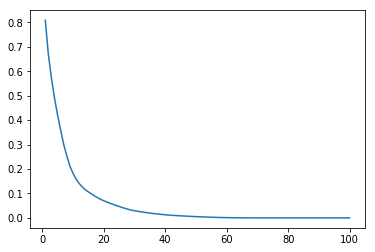

In [53]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

%matplotlib inline

#not very relevant to recommendation but keep it anyway
n_components = 100
pca = PCA(n_components=n_components)
transformed = pca.fit_transform(mat) 

evr = [1-sum(pca.explained_variance_ratio_[:i+1]) for i in range(len(pca.explained_variance_ratio_))]
plt.plot(range(1,n_components+1),evr)

# Loss Function and Gradient #

In [64]:
n_features = 20
filter_size = 50
mat = mat[:,range(filter_size)] if len(mat[0])>filter_size else mat #for speed
global mask,n_repos,n_langs,reg_param
reg_param = 0.005

#mask
def init_mask(Y=mat):
    f = np.vectorize(lambda x: 1 if x>0 else 0)
    return f(Y),len(Y),len(Y[0])

#loss
def loss(args, Y=mat):
    theta = np.reshape(args[:n_repos*n_features],(n_repos,n_features))
    X = np.reshape(args[n_repos*n_features:],(n_langs,n_features))
    g = np.vectorize(lambda x: x*x)
    return 0.5*np.sum(np.multiply(g(np.subtract(np.matmul(theta,np.transpose(X)),Y)),mask))+reg_param/2*np.sum(g(args))

#gradient
def gradient(args, Y=mat):
    theta = np.reshape(args[:n_repos*n_features],(n_repos,n_features))
    X = np.reshape(args[n_repos*n_features:],(n_langs,n_features))
    X_grad = np.matmul(np.transpose(np.multiply(np.subtract(np.matmul(theta,np.transpose(X)),Y),mask)),theta)+reg_param*X
    theta_grad = np.matmul(np.multiply(np.subtract(np.matmul(theta,np.transpose(X)),Y),mask),X)+reg_param*theta
    return np.concatenate((np.reshape(theta_grad,-1),np.reshape(X_grad,-1)))

# Training #

In [65]:
def train(Y=mat):
    import scipy.optimize as op

    theta = np.random.rand(n_repos,n_features)
    X = np.random.rand(n_langs,n_features)
    args = np.concatenate((np.reshape(theta,-1),np.reshape(X,-1)))

    args = op.fmin_cg(loss,args,gradient)

    theta = np.reshape(args[:n_repos*n_features],(n_repos,n_features))
    X = np.reshape(args[n_repos*n_features:],(n_langs,n_features))
    
    return theta,X
'''
def learning_rate(i):
    #return alpha/(i+1)
    return alpha

cur = 1000000
for i in range(100):
    theta_grad,X_grad = gradient(theta,X,mat)
    theta,X = theta+theta_grad*learning_rate(i),X+X_grad*learning_rate(i)
    prev = cur
    cur = loss(theta,X,mat)
    print cur
    if cur>prev:
        print theta
        print X
        print theta_grad
        print X_grad
'''

'\ndef learning_rate(i):\n    #return alpha/(i+1)\n    return alpha\n\ncur = 1000000\nfor i in range(100):\n    theta_grad,X_grad = gradient(theta,X,mat)\n    theta,X = theta+theta_grad*learning_rate(i),X+X_grad*learning_rate(i)\n    prev = cur\n    cur = loss(theta,X,mat)\n    print cur\n    if cur>prev:\n        print theta\n        print X\n        print theta_grad\n        print X_grad\n'

# Recommendations #

In [66]:
string = raw_input()
langs = string.split(' ')
lc_names = {str(name).lower(): name_to_index[name] for name in name_to_index}

test = np.zeros((1,len(names)))
known = set()
for lang in langs:
    if lang.lower() in lc_names:
        test[0][lc_names[lang.lower()]] = 1
        known.add(lc_names[lang.lower()])
                       
mat = np.concatenate((mat,test[:,range(filter_size)]),0)
mask,n_repos,n_langs = init_mask()
theta,X = train(mat)
mat = mat[:-1]
    
predictions = np.matmul(theta,np.transpose(X))[-1].tolist()
predictions = sorted([(j,i) for i,j in enumerate(predictions)],reverse=True)
    
i = 0
for val,name in predictions:
    if name not in known:
        print str(i+1)+': '+names[name]+' - '+str(val)
        i+=1
    if i>=10:
        break

typescript c# javascript php
Optimization terminated successfully.
         Current function value: 0.353045
         Iterations: 3433
         Function evaluations: 5189
         Gradient evaluations: 5189
1: Java - 0.202951306315
2: Ruby - 0.198711626435
3: Go - 0.169384198952
4: C++ - 0.168596053185
5: C - 0.132115778127
6: Python - 0.127616392501
7: Perl - 0.123206452534
8: Rust - 0.120726032547
9: Haskell - 0.1153720885
10: HTML - 0.114071001001
